In [1]:
from dsc80_utils import *
import lec15_util as util

# Lecture 15 – Pipelines, Multicollinearity, and Generalization

## DSC 80, Fall 2024

### Announcements 📣

- Lab 7 due tomorrow.
- Final Project Checkpoint 1 due Tuesday.
- Midterm Rdemption due Wednesday.

### Agenda 📆

- Pipelines.
- Multicollinearity.
- Generalization.
    - Bias and variance.
    - Train-test splits.

## Pipelines

<center><img src="imgs/image_0.png" width="50%"></center>

<br>

So far, we've used transformers for feature engineering and models for prediction. We can combine these steps into a single `Pipeline`.

### `Pipeline`s in `sklearn`

From [`sklearn`'s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

> Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, **if desired**, conclude the sequence with a final predictor for predictive modeling.<br><br>Intermediate steps of the pipeline must be "transforms", that is, they must implement `fit` and `transform` methods. The final estimator only needs to implement `fit`.

- General template: `pl = Pipeline([trans_1, trans_2, ..., model])`
    - Note that the `model` is optional.

- Once a `Pipeline` is instantiated, you can fit **all** steps (transformers and model) using `pl.fit(X, y)`.

- To make predictions using **raw, untransformed data**, use `pl.predict(X)`.

- The actual list we provide `Pipeline` with must be a list of **tuples**, where
    - The first element is a "name" (that we choose) for the step.
    - The second element is a transformer or estimator instance.

### Our first `Pipeline`

Let's build a `Pipeline` that:
- One hot encodes the categorical features in `tips`.
- Fits a regression model on the one hot encoded data.

In [2]:
tips = px.data.tips()

In [3]:
tips_cat = tips[['sex', 'smoker', 'day', 'time']]
tips_cat.head()

,sex,smoker,day,time
0,Female,No,Sun,Dinner
1,Male,No,Sun,Dinner
2,Male,No,Sun,Dinner
3,Male,No,Sun,Dinner
4,Female,No,Sun,Dinner


In [4]:
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

pl = Pipeline([
    ('one-hot', OneHotEncoder()),
    ('lin-reg', LinearRegression())
])

Now that `pl` is instantiated, we `fit` it the same way we would fit the individual steps.

In [6]:
pl.fit(tips_cat, tips['tip'])

Pipeline(steps=[('one-hot', OneHotEncoder()), ('lin-reg', LinearRegression())])

Now, to make predictions using **raw data**, all we need to do is use `pl.predict`:

In [7]:
pl.predict(tips_cat.iloc[:5])

array([3.1 , 3.27, 3.27, 3.27, 3.1 ])

`pl` performs **both** feature transformation and prediction with just a single call to `predict`!

We can access individual "steps" of a `Pipeline` through the `named_steps` attribute:

In [8]:
pl.named_steps

{'one-hot': OneHotEncoder(), 'lin-reg': LinearRegression()}

In [9]:
pl.named_steps['one-hot'].transform(tips_cat).toarray()

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

In [10]:
pl.named_steps['one-hot'].get_feature_names_out()

array(['sex_Female', 'sex_Male', 'smoker_No', 'smoker_Yes', 'day_Fri',
       'day_Sat', 'day_Sun', 'day_Thur', 'time_Dinner', 'time_Lunch'],
      dtype=object)

In [11]:
pl.named_steps['lin-reg'].coef_

array([-0.09,  0.09, -0.04,  0.04, -0.2 , -0.13,  0.14,  0.19,  0.25,
       -0.25])

`pl` also has a `score` method, the same way a fit `LinearRegression` instance does:

In [12]:
# Why is this so low?
pl.score(tips_cat, tips['tip'])

0.02749679020147555

### More sophisticated `Pipeline`s

- In the previous example, we one hot encoded every input column. **What if we want to perform different transformations on different columns?**

- **Solution**: Use a `ColumnTransformer`.
    - Instantiate a `ColumnTransformer` using a list of tuples, where:
        - The first element is a "name" we choose for the transformer.
        - The second element is a transformer instance (e.g. `OneHotEncoder()`).
        - The third element is a **list of relevant column names**.

### Planning our first `ColumnTransformer`

In [13]:
from sklearn.compose import ColumnTransformer

Let's perform different transformations on the quantitative and categorical features of `tips` (note that we are not transforming `'tip'`).

In [14]:
tips_features = tips.drop('tip', axis=1)
tips_features.head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


- We will leave the `'total_bill'` column untouched.

- To the `'size'` column, we will apply the `Binarizer` transformer with a threshold of 2 (big tables vs. small tables).

- To the categorical columns, we will apply the `OneHotEncoder` transformer.


- In essence, we will create a transformer that reproduces the following DataFrame:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>size</th>
      <th>x0_Female</th>
      <th>x0_Male</th>
      <th>x1_No</th>
      <th>x1_Yes</th>
      <th>x2_Fri</th>
      <th>x2_Sat</th>
      <th>x2_Sun</th>
      <th>x2_Thur</th>
      <th>x3_Dinner</th>
      <th>x3_Lunch</th>
      <th>total_bill</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>16.99</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>10.34</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>21.01</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>23.68</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>24.59</td>
    </tr>
  </tbody>
</table>


### Building a `Pipeline` using a `ColumnTransformer`

Let's start by creating our `ColumnTransformer`.

In [72]:
from sklearn.preprocessing import Binarizer

preproc = ColumnTransformer(
    transformers=[
        ('size', Binarizer(threshold=2), ['size']),
        ('categorical_cols', OneHotEncoder(), ['sex', 'smoker', 'day', 'time'])
    ],
    # Specify what to do with all other columns ('total_bill' here) – drop or passthrough.
    remainder='passthrough',
    # Keep original dtypes for remaining columns
    force_int_remainder_cols=False,
)

Now, let's create a `Pipeline` using `preproc` as a transformer, and `fit` it:

In [73]:
pl = Pipeline([
    ('preprocessor', preproc), 
    ('lin-reg', LinearRegression())
])

In [74]:
pl.fit(tips_features, tips['tip'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('size',
                                                  Binarizer(threshold=2),
                                                  ['size']),
                                                 ('categorical_cols',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('lin-reg', LinearRegression())])

Prediction is as easy as calling `predict`:

In [75]:
tips_features.head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


In [76]:
# Note that we fit the Pipeline using tips_features, not tips_features.head()!
pl.predict(tips_features.head())

array([2.74, 2.32, 3.37, 3.37, 3.75])

### Aside: `FunctionTransformer`

A transformer you'll often use as part of a `ColumnTransformer` is the `FunctionTransformer`, which enables you to use your own functions on entire columns. Think of it as the `sklearn` equivalent of `apply`.

In [77]:
from sklearn.preprocessing import FunctionTransformer

In [78]:
f = FunctionTransformer(np.sqrt)
f.transform([1, 2, 3])

array([1.  , 1.41, 1.73])

### 💡 Pro-Tip: Using `make_pipeline` and `make_column_transformer`

Instead of using `Pipeline` and `ColumnTransformer` classes directly, `scikit-learn` provides nifty shortcut methods called `make_pipeline` and `make_column_transformer`:

In [79]:
# Old code

preproc = ColumnTransformer(
    transformers=[
        ('size', Binarizer(threshold=2), ['size']),
        ('categorical_cols', OneHotEncoder(), ['sex', 'smoker', 'day', 'time'])
    ],
    remainder='passthrough' 
)

pl = Pipeline([
    ('preprocessor', preproc), 
    ('lin-reg', LinearRegression())
])

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

preproc = make_column_transformer(
    (Binarizer(threshold=2), ['size']),
    (OneHotEncoder(), ['sex', 'smoker', 'day', 'time']),
    remainder='passthrough',
)

pl = make_pipeline(preproc, LinearRegression())
# Notice that the steps in the pipeline and column transformer are
# automatically named
pl

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binarizer',
                                                  Binarizer(threshold=2),
                                                  ['size']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('linearregression', LinearRegression())])

### An example `Pipeline`

One of the transformers we used was the `StandardScaler` transformer, which **standardizes** columns.

$$z(x_i) = \frac{x_i - \text{mean of } x}{\text{SD of } x}$$

Let's build a `Pipeline` that:
- Takes in the `'total_bill'` and `'size'` features of `tips`.
- Standardizes those features.
- Uses the resulting standardized features to fit a linear model that predicts `'tip'`.

In [81]:
# Let's define these once, since we'll use them repeatedly.
X = tips[['total_bill', 'size']]
y = tips['tip']

In [82]:
from sklearn.preprocessing import StandardScaler

model_with_std = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)


model_with_std.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

How well does our model do? We can compute its $R^2$ and RMSE.

In [83]:
model_with_std.score(X, y)

0.46786930879612587

In [87]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y, model_with_std.predict(X))

np.float64(1.007256127114662)

Does this model perform any better than one that _doesn't_ standardize its features? Let's find out.

In [88]:
model_without_std = LinearRegression()
model_without_std.fit(X, y)

LinearRegression()

In [89]:
model_without_std.score(X, y)

0.46786930879612587

In [90]:
root_mean_squared_error(y, model_without_std.predict(X))

np.float64(1.007256127114662)

**No!**

### The purpose of standardizing features

If you're performing "vanilla" linear regression – that is, using the `LinearRegression` object – then standardizing your features **will not** change your model's error.

- There are other models where standardizing your features _will_ improve performance, because the methods assume features are standardized.
    - Regularized linear regression (see [DSC 140A](https://dsc140a.com)).
    - PCA (assumes centered data, not necessarily standardized: see [DSC 140B](https://dsc140b.com)).
    - Clustering algorithms, e.g. $k$-means clustering (saw in DSC 40A!).

- There _is_ a benefit to standardizing features when performing vanilla linear regression, as we saw in DSC 40A: the features are brought to the same scale, so the coefficients can be compared directly.

In [91]:
# Total bill, table size.
model_without_std.coef_

array([0.09, 0.19])

In [92]:
# Total bill, table size.
model_with_std.named_steps['linearregression'].coef_

array([0.82, 0.18])

### Aside: `Pipeline`s of just transformers

If you want to apply multiple transformations to the same column in a dataset, you can create a `Pipeline` just for that column.

For example, suppose we want to:
- One hot encode the `'sex'`, `'smoker'`, and `'time'` columns.
- One hot encode the `'day'` column, but as either `'Weekday'`, `'Sat'`, or `'Sun'`.
- Binarize the `'size'` column.

Here's how we might do that:

In [99]:
def is_weekend(s):
    # The input to is_weekend is a Series!
    return s.replace({'Thur': 'Weekday', 'Fri': 'Weekday'})

In [100]:
pl_day = make_pipeline(
    FunctionTransformer(is_weekend),
    OneHotEncoder(),
)

In [101]:
col_trans = make_column_transformer(
    (pl_day, ['day']),
    (OneHotEncoder(drop='first'), ['sex', 'smoker', 'time']),
    (Binarizer(threshold=2), ['size']),
    remainder='passthrough',
    force_int_remainder_cols=False,
)

In [102]:
pl = make_pipeline(
    col_trans,
    LinearRegression(),
)

pl.fit(tips.drop('tip', axis=1), tips['tip'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function is_weekend at 0x3263f4d60>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['day']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'time']),
                                                 ('binarizer',
                                                  Binarizer(threshold=2),
                                                  ['size'])])),
                ('linearregression', LinearRegression())])

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `weights`
</div>

How many weights does this linear model have?

## Multicollinearity

### Heights and weights

We have a dataset containing the weights and heights of 25,000 18 year olds, taken from [here](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights).

In [103]:
people_path = Path('data') / 'SOCR-HeightWeight.csv'
people = pd.read_csv(people_path).drop(columns=['Index'])
people.head()

,Height (Inches),Weight (Pounds)
0,65.78,112.99
1,71.52,136.49
2,69.40,153.03
3,68.22,142.34
4,67.79,144.30


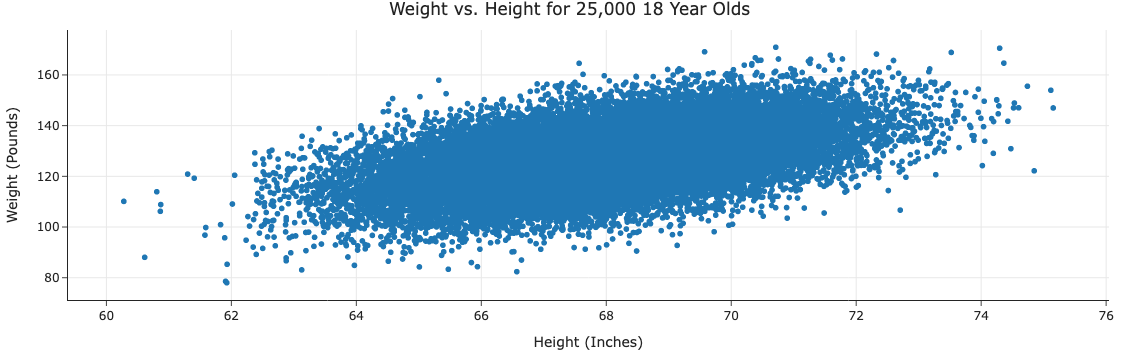

In [104]:
people.plot(kind='scatter', x='Height (Inches)', y='Weight (Pounds)', 
            title='Weight vs. Height for 25,000 18 Year Olds')

### Motivating example

Suppose we fit a simple linear regression model that uses **height in inches** to predict **weight in pounds**.

$$\text{predicted weight (pounds)} = w_0 + w_1 \cdot \text{height (inches)}$$

In [105]:
X = people[['Height (Inches)']]
y = people['Weight (Pounds)']

In [106]:
lr_one_feat = LinearRegression()
lr_one_feat.fit(X, y)

LinearRegression()

$w_0^*$ and $w_1^*$ are shown below, along with the model's training set RMSE.

In [107]:
lr_one_feat.intercept_, lr_one_feat.coef_

(np.float64(-82.57574306454093), array([3.08]))

In [110]:
root_mean_squared_error(y, lr_one_feat.predict(X))

np.float64(10.079113675632819)

Now, suppose we fit another regression model, that uses **height in inches** AND **height in centimeters** to predict weight.

$$\text{predicted weight (pounds)} = w_0 + w_1 \cdot \text{height (inches)} + w_2 \cdot \text{height (cm)}$$

In [111]:
people['Height (cm)'] = people['Height (Inches)'] * 2.54 # 1 inch = 2.54 cm

In [112]:
X2 = people[['Height (Inches)', 'Height (cm)']]

In [113]:
lr_two_feat = LinearRegression()
lr_two_feat.fit(X2, y)

LinearRegression()

What are $w_0^*$, $w_1^*$, $w_2^*$, and the model's test RMSE?

In [114]:
lr_two_feat.intercept_, lr_two_feat.coef_

(np.float64(-82.57525639659859), array([ 3.38e+10, -1.33e+10]))

In [115]:
root_mean_squared_error(y, lr_two_feat.predict(X2))

np.float64(10.079113677131511)

**Observation**: The intercept is the same as before (roughly -82.57), as is the RMSE. However, the coefficients on `'Height (Inches)'` and `'Height (cm)'` are massive in size!

What's going on?

### Redundant features

Let's use simpler numbers for illustration. Suppose in the first model, $w_0^* = -80$ and $w_1^* = 3$.

$$\text{predicted weight (pounds)} = -80 + 3 \cdot \text{height (inches)}$$

In the second model, we have:

$$\begin{align*}\text{predicted weight (pounds)} &= w_0^* + w_1^* \cdot \text{height (inches)} + w_2^* \cdot \text{height (cm)} \\ &= w_0^* + w_1^* \cdot \text{height (inches)} + w_2^* \cdot \big( 2.54^* \cdot \text{height (inches)} \big) \\ &= w_0^* + \left(w_1^* + 2.54 \cdot w_2^* \right) \cdot \text{height (inches)} \end{align*}$$

In the first model, we already found the "best" intercept ($-80$) and slope ($3$) in a linear model that uses height in inches to predict weight.

**So, as long as $w_1^* + 2.54 \cdot w_2^* = 3$ in the second model, the second model's training predictions will be the same as the first, and hence they will also minimize RMSE.**

### Infinitely many parameter choices

**Issue**: There are an infinite number of $w_1^*$ and $w_2^*$ that satisfy $w_1^* + 2.54 \cdot w_2^* = 3$!

$$\text{predicted weight} = -80 - 10 \cdot \text{height (inches)} + \frac{13}{2.54} \cdot \text{height (cm)}$$

$$\text{predicted weight} = -80 + 10 \cdot \text{height (inches)} - \frac{7}{2.54} \cdot \text{height (cm)}$$

- Both prediction rules look very different, but actually make the same predictions.


- `lr.coef_` could return either set of coefficients, or any other of the infinitely many options. 


- But neither set of coefficients is **has any meaning!**

In [116]:
(-80 - 10 * people.iloc[:, 0] + (13 / 2.54) * people.iloc[:, 2]).head()

0    117.35
1    134.55
2    128.20
3    124.65
4    123.36
dtype: float64

In [117]:
(-80 + 10 * people.iloc[:, 0] - (7 / 2.54) * people.iloc[:, 2]).head()

0    117.35
1    134.55
2    128.20
3    124.65
4    123.36
dtype: float64

### Multicollinearity

- Multicollinearity occurs when features in a regression model are **highly correlated** with one another.
    - In other words, multicollinearity occurs when **a feature can be predicted using a linear combination of other features, fairly accurately**.

- When multicollinearity is present in the features, the **coefficients in the model** are uninterpretable – they have no meaning.
    - A "slope" represents "the rate of change of $y$ with respect to a feature", when all other features are held constant – but if there's multicollinearity, you can't hold other features constant.

- **Note: Multicollinearity doesn't impact a model's predictions!**
    - It doesn't impact a model's ability to generalize to unseen data.
    - If features are multicollinear in the training data, they will probably be multicollinear in the test data too.

- **Solutions**:
    - Manually remove highly correlated features.
    - Use a dimensionality reduction technique (such as PCA) to automatically reduce dimensions.

### Example: One hot encoding

**A one hot encoding will result in multicollinearity unless you drop one of the one hot encoded features.**

Suppose we have the following fitted model:

$$
\begin{aligned}
H(x) = 1 + 2 \cdot (\text{smoker==Yes}) - 2 \cdot (\text{smoker==No})
\end{aligned}
$$

This is equivalent to:

$$
\begin{aligned}
H(x) = 10 - 7 \cdot (\text{smoker==Yes}) - 11 \cdot (\text{smoker==No})
\end{aligned}
$$

Solution: Drop one of the one hot encoded columns. `sklearn.preprocessing.OneHotEncoder` has an option to do this.

### Key takeaways

- Multicollinearity is present in a linear model when one feature can be accurately predicted using one or more other features.
    - In other words, it is present when a feature is **redundant**.

- Multicollinearity doesn't pose an issue for prediction; it doesn't hinder a model's ability to generalize. Instead, it renders the **coefficients** of a linear model meaningless.

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `wi23q9`
</div>

(Wi23 Final Q9)

One piece of information that may be useful as a feature is the proportion of SAT test takers in a state in a given year that qualify for free lunches in school. The Series `lunch_props` contains 8 values, each of which are either `"low"`, `"medium"`, or `"high"`. Since we can’t use strings as features in a model, we decide to encode these strings using the following Pipeline:

```python
# Note: The FunctionTransformer is only needed to change the result
# of the OneHotEncoder from a "sparse" matrix to a regular matrix
# so that it can be used with StandardScaler;
# it doesn't change anything mathematically.
pl = Pipeline([
    ("ohe", OneHotEncoder(drop="first")),
    ("ft", FunctionTransformer(lambda X: X.toarray())),
    ("ss", StandardScaler())
])
```

After calling `pl.fit(lunch_props)`, `pl.transform(lunch_props)` evaluates to the following array:

```python
array([[ 1.29099445, -0.37796447],
       [-0.77459667, -0.37796447],
       [-0.77459667, -0.37796447],
       [-0.77459667,  2.64575131],
       [ 1.29099445, -0.37796447],
       [ 1.29099445, -0.37796447],
       [-0.77459667, -0.37796447],
       [-0.77459667, -0.37796447]])
```

and `pl.named_steps["ohe"].get_feature_names()` evaluates to the following array:

```python
array(["x0_low", "x0_med"], dtype=object)
```

Fill in the blanks: Given the above information, we can conclude that lunch_props has ____________ value(s) equal to "low", ____________ value(s) equal to "medium", and _____________ value(s) equal to "high". (Note: You should write one positive integer in each box such that the numbers add up to 8.)

## Generalization

### Motivation

- You and Billy are studying for an upcoming exam. You both decide to test your understanding by taking a **practice exam**.
    - Your logic: If you do well on the practice exam, you should do well on the real exam.

- You each take the practice exam once and look at the solutions afterwards.

- **Your strategy**: Memorize the answers to all practice exam questions, e.g. "Question 1: A; Question 2: C; Question 3: A."

- **Billy's strategy**: Learn high-level concepts from the solutions, e.g. "data are NMAR if the likelihood of missingness depends on the missing values themselves."

- Who will do better on the **practice exam**? Who will probably do better on the **real exam**? 🧐

### Evaluating the quality of a model

- So far, we've computed the RMSE (and $R^2$) of our fit regression models on the **data that we used to fit them**, i.e. the **training data**.

- We've said that Model A is **better** than Model B if Model A's RMSE is **lower** than Model B's RMSE.
    - Remember, our **training data** is a sample from some population.
    - Just because a model fits the training data well doesn't mean it will **generalize** and work well on **similar, unseen samples** from the same population!

### Example: Overfitting and underfitting

Let's collect two samples $\{(x_i, y_i)\}$ from the same population.

In [118]:
np.random.seed(23) # For reproducibility.

def sample_from_pop(n=100):
    x = np.linspace(-2, 3, n)
    y = x ** 3 + (np.random.normal(0, 3, size=n))
    return pd.DataFrame({'x': x, 'y': y})

sample_1 = sample_from_pop()
sample_2 = sample_from_pop()

For now, let's just look at Sample 1. The relationship between $x$ and $y$ is roughly **cubic**; that is, $y \approx x^3$ (remember, in reality, you won't get to see the population).

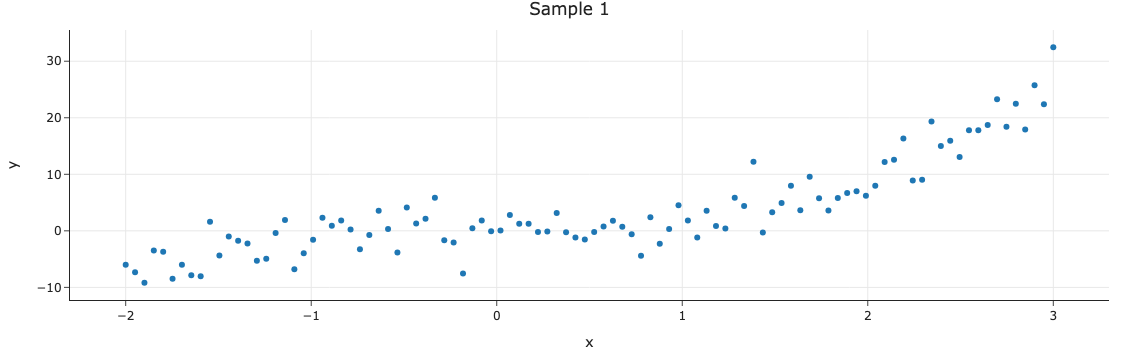

In [119]:
px.scatter(sample_1, x='x', y='y', title='Sample 1')

### Polynomial regression

Let's fit three **polynomial** models on Sample 1:
- Degree 1.
- Degree 3.
- Degree 25.

The `PolynomialFeatures` transformer will be helpful here.

In [120]:
from sklearn.preprocessing import PolynomialFeatures

In [121]:
# fit_transform fits and transforms the same input.
d2 = PolynomialFeatures(3)
d2.fit_transform(np.array([1, 2, 3, 4, -2]).reshape(-1, 1))

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.],
       [ 1., -2.,  4., -8.]])

Below, we look at our three models' predictions on Sample 1 (which they were trained on).

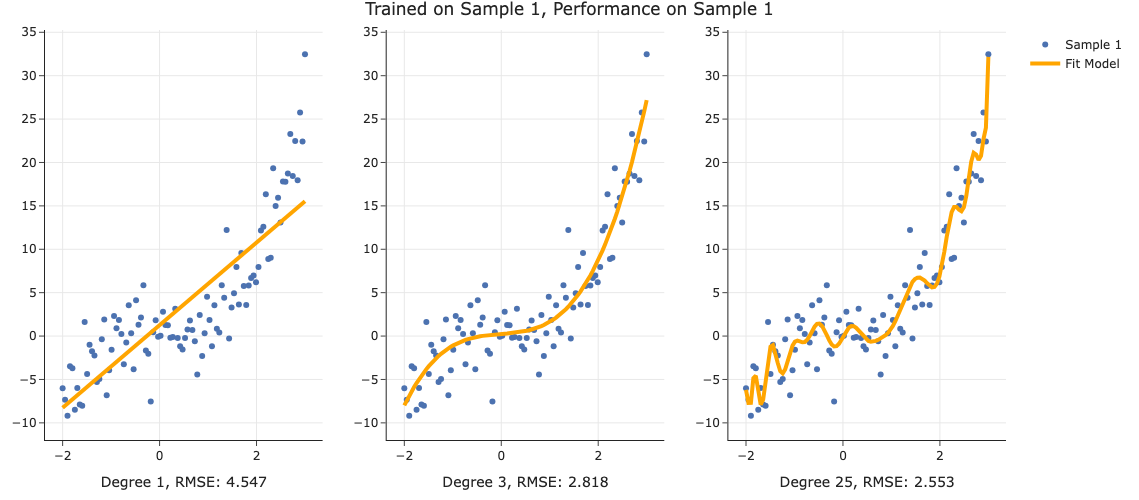

In [122]:
# Look at the definition of train_and_plot in lec15_util.py if you're curious as to how the plotting works.
fig = util.train_and_plot(train_sample=sample_1, test_sample=sample_1, degs=[1, 3, 25], data_name='Sample 1')
fig.update_layout(title='Trained on Sample 1, Performance on Sample 1')

The degree 25 polynomial has the lowest RMSE on Sample 1.

How do the same fit polynomials look on Sample 2?

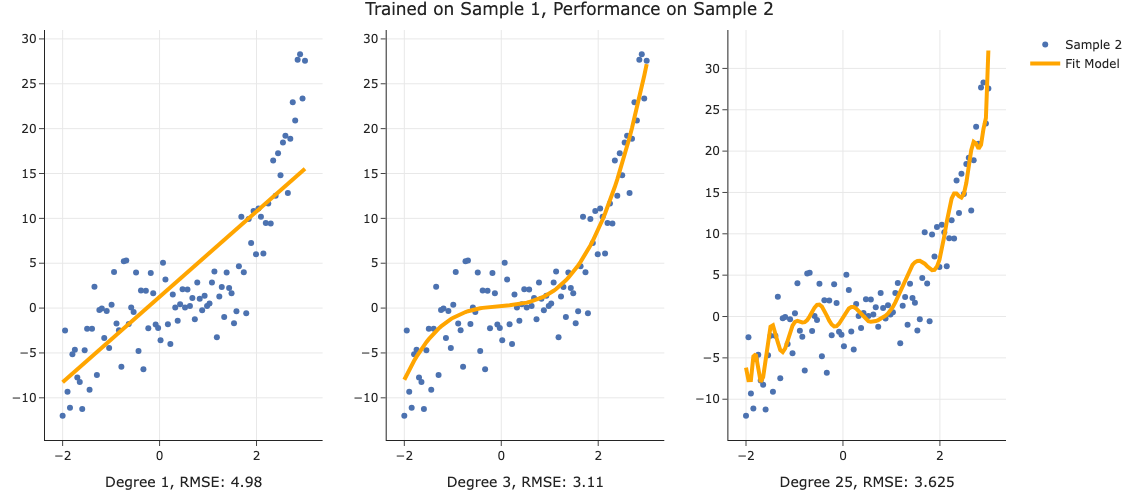

In [123]:
fig = util.train_and_plot(train_sample=sample_1, test_sample=sample_2, degs=[1, 3, 25], data_name='Sample 2')
fig.update_layout(title='Trained on Sample 1, Performance on Sample 2')

- The degree 3 polynomial has the lowest RMSE on Sample 2. 

- Note that **we didn't get to see Sample 2 when fitting our models**! 

- As such, it seems that the degree 3 polynomial **generalizes better** to unseen data than the degree 25 polynomial does.

What if we fit a degree 1, degree 3, and degree 25 polynomial **on Sample 2** as well?

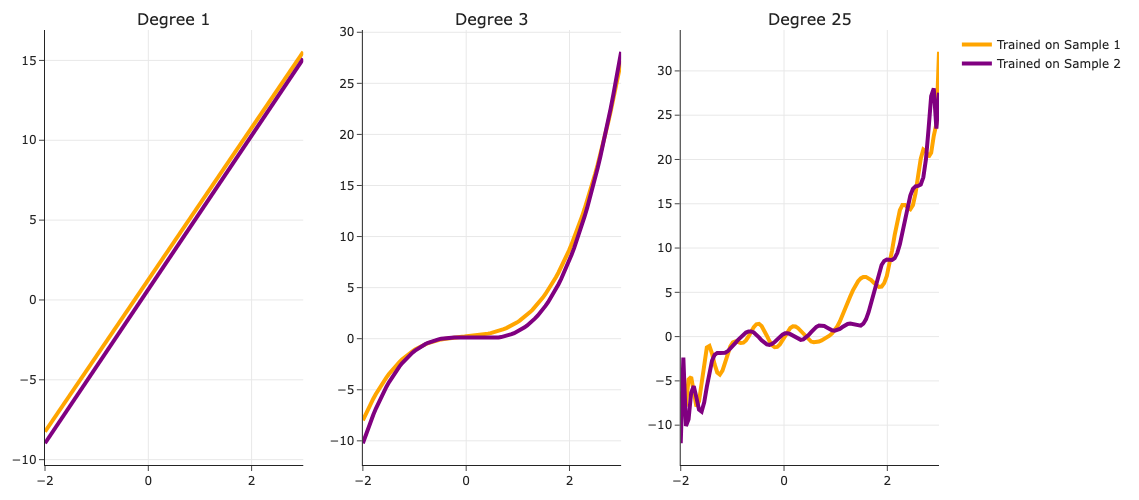

In [124]:
util.plot_multiple_models(sample_1, sample_2, degs=[1, 3, 25])

**Key idea**: Degree 25 polynomials seem to **vary more when trained on different samples** than degree 3 and 1 polynomials do.

### Bias and variance

The training data we have access to is a sample from the population. We are concerned with our model's ability to **generalize** and work well on **different datasets** drawn from the same population.

Suppose we **fit** a model $H$ (e.g. a degree 3 polynomial) on **several different datasets** from a population. There are three sources of error that arise:

* ⭐️ **Bias**: **The expected deviation between a predicted value and an actual value**.
    - In other words, **for a given $x_i$, how far is $H(x_i)$ from the true $y_i$, on average?**
    - Low bias is good! ✅
    - High bias is a sign of **underfitting**, i.e. that our model is too **basic** to capture the relationship between our features and response.

- ⭐️ **Model variance ("variance")**: **The variance of a model's predictions**.
    - In other words, **for a given $x_i$, how much does $H(x_i)$ vary across all datasets**?
    - Low model variance is good! ✅
    - High model variance is a sign of **overfitting**, i.e. that our model is too **complicated** and is prone to fitting to the noise in our training data.

- **Observation error**: The error due to the random noise in the process we are trying to model (e.g. measurement error). _We can't control this, without collecting more data!_

Here, suppose:
- The <span style='color:#c6283f'><b>red bulls-eye</b></span> represents your **true weight and height** 🧍.
- The <span style='color:#080c6f'><b>dark blue darts</b></span> represent **predictions of your weight and height** using different models that were fit on the same DGP. 
<br>

<center><img src="imgs/image_5.png" width="40%"></center>

We'd like our models to be in the top left, but in practice that's hard to achieve!

### Risk vs. empirical risk

- In DSC 40A, we started using **empirical risk minimization** to find optimal model parameters $w^*$:

$$
\text{choose the $w$ such that } \frac{1}{n} \sum_{i = 1}^n \left( y_i - H(x_i) \right)^2 \text{ is minimized}$$

<center>or, equivalently:</center>

$$w^* = \underset{w}{\text{argmin}} \frac{1}{n} \sum_{i = 1}^n \left( y_i - H(x_i) \right)^2$$

- **Key idea**: A model that works well on past data should work well on future data, if future data looks like past data.

- What we really want is for the **expected loss for a new data point $(x_{\text{new}}, y_{\text{new}})$, drawn from the same population as the training set, to be small**. That is, we want
    $$\mathbb{E}[y_{\text{new}} - H(x_{\text{new}})]^2$$
    to be minimized. The quantity above is called **risk**.

- What's that fancy $\mathbb{E}$? It is the **expectation** operator of a random variable: it computes the **average value** of the random variable across its entire distribution.
    - (From Math 183/180A) If $X \sim \text{Binomial}(n, p)$, then $\mathbb{E}[X] = np$.

- In general, we don't know the entire population distribution of $x$s and $y$s, so we can't compute risk exactly. That's why we compute **empirical risk**!

$$\mathbb{E}[y_{\text{new}} - H(x_{\text{new}})]^2 \approx \frac{1}{n} \sum_{i = 1}^n \left( y_i - H(x_i) \right)^2$$

### The bias-variance decomposition

Risk can be decomposed as follows:

$$\mathbb{E}[y_{\text{new}} - H(x_{\text{new}})]^2 = \text{model bias}^2 + \text{model variance} + \text{observation error}$$

- Remember, this expectation $\mathbb{E}$ is over the entire population of $x$s and $y$s: in real life, we don't know what this population distribution is, so we can't put actual numbers to this.

- If $H$ is too simple to capture the relationship between $x$s and $y$s in the population, $H$ will **underfit** to training sets and have **high bias**.

- If $H$ is overly complex, $H$ will **overfit** to training sets and have **high variance**, meaning it will change significantly from one training set to the next.

- Generally:
    - Training error reflects bias, **not variance**.
    - Test error reflects **both bias and variance**.

### Navigating the bias-variance tradeoff

$$\mathbb{E}[y_{\text{new}} - H(x_{\text{new}})]^2 = \text{model bias}^2 + \text{model variance} + \text{observation error}$$

- As we collect more data points (i.e. as $n \uparrow$):
    - Model variance decreases.
    - If $H$ can exactly model the true population relationship between $x$ and $y$ (e.g. cubic), then model bias also decreases.
    - If $H$ can't exactly model the true population relationship between $x$ and $y$, then model bias will remain large.

- As we add more features (i.e. as $d \uparrow$):
    - Model variance increases, whether or not the feature was useful.
    - Adding a useful feature decreases model bias.
    - Adding a useless feature doesn't change model bias.

- Example: suppose the actual relationship between $x$ and $y$ in the population is linear, and we fit $H$ using simple linear regression.
    - Model bias = 0.
    - Model variance $\propto \frac{d}{n}$.
        - As $d \uparrow$, model variance $\uparrow$.
        - As $n \uparrow$, model variance $\downarrow$.

Read more [here](https://learningds.org/ch/17/inf_pred_gen_prob.html#probability-behind-model-selection).

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `fa23q94`
</div>

(Fa23 Final 9.4)

Determine how each change below affects model bias and variance compared to this model:

<center><img src='imgs/hx.png' width=50%></center>

For each change, choose all of the following that apply: **increase bias, decrease bias, increase variance, decrease variance.**

1. Add degree 3 polynomial features.
1. Add a feature of numbers chosen at random between 0 and 1.
1. Collect 100 more points for the training set.
1. Don’t use the 'veg' feature.

## Train-test splits

### Avoiding overfitting

- We won't know whether our model has **overfit** to our sample (training data) unless we get to see how well it performs on a new sample from the same population.

- 💡**Idea**: **Split** our sample into a **training set** and **test set**.

- Use **only** the training set to fit the model (i.e. find $w^*$).

- Use the test set to evaluate the model's error (RMSE, $R^2$).

- The test set is like a new sample of data from the same population as the training data!

<center><img src="imgs/train-test.png" width='50%'></center>

### Train-test split 🚆

`sklearn.model_selection.train_test_split` implements a train-test split for us! 🙏🏼 

If `X` is an array/DataFrame of features and `y` is an array/Series of responses,

```py
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
```

randomly splits the features and responses into training and test sets, such that the test set contains 0.25 of the full dataset.

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
# Read the documentation!
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

Let's perform a train/test split on our `tips` dataset.

In [127]:
X = tips.drop('tip', axis=1)
y = tips['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # We don't have to choose 0.25.

Before proceeding, let's check the sizes of `X_train` and `X_test`.

In [128]:
print('Rows in X_train:', X_train.shape[0])
display(X_train.head())
print('Rows in X_test:', X_test.shape[0])
display(X_test.head())

Rows in X_train: 195


,total_bill,sex,smoker,day,time,size
4,24.59,Female,No,Sun,Dinner,4
209,12.76,Female,Yes,Sat,Dinner,2
178,9.60,Female,Yes,Sun,Dinner,2
230,24.01,Male,Yes,Sat,Dinner,4
5,25.29,Male,No,Sun,Dinner,4


Rows in X_test: 49


,total_bill,sex,smoker,day,time,size
146,18.64,Female,No,Thur,Lunch,3
224,13.42,Male,Yes,Fri,Lunch,2
134,18.26,Female,No,Thur,Lunch,2
131,20.27,Female,No,Thur,Lunch,2
147,11.87,Female,No,Thur,Lunch,2


In [129]:
X_train.shape[0] / tips.shape[0]

0.7991803278688525

### Example train-test split

Steps:
1. Fit a model on the training set.
2. Evaluate the model on the test set.

In [130]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [131]:
X = tips[['total_bill', 'size']] # For this example, we'll use just the already-quantitative columns in tips.
y = tips['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # random_state is like np.random.seed.

Here, we'll use a stand-alone `LinearRegression` model without a `Pipeline`, but this process would work the same if we were using a `Pipeline`.

In [132]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Let's check our model's performance on the **training** set first.

In [133]:
pred_train = lr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, pred_train)
rmse_train

np.float64(0.9803205287924736)

And the **test** set:

In [134]:
pred_test = lr.predict(X_test)
rmse_test = root_mean_squared_error(y_test, pred_test)
rmse_test

np.float64(1.1381771291131253)

Since `rmse_train` and `rmse_test` are similar, it **doesn't seem like our model is overfitting** to the training data. If `rmse_test` was much larger than `rmse_train`, it would be evidence that our model is unable to **generalize well**.

## Hyperparameters

### Example: Polynomial regression

We recently looked at an example of **polynomial regression**.

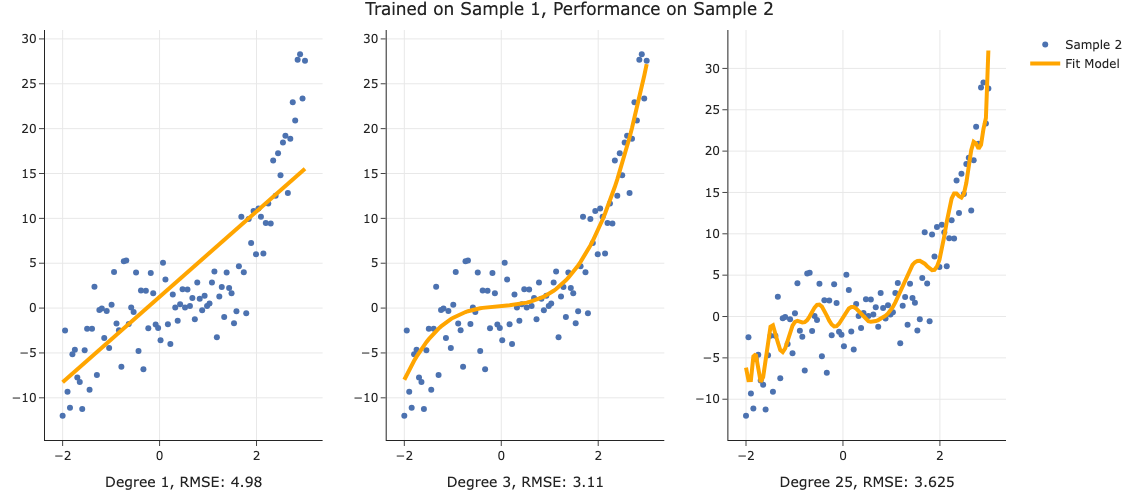

In [135]:
fig = util.train_and_plot(train_sample=sample_1, test_sample=sample_2, degs=[1, 3, 25], data_name='Sample 2')
fig.update_layout(title='Trained on Sample 1, Performance on Sample 2')

When building these models:
- We **got to choose** the degree of the polynomials (i.e. we chose 1, 3, and 25).
- We didn't get to choose the exact formulas for the three polynomials – their formulas were **learned from data**.

### Parameters vs. hyperparameters

- A **parameter** defines the relationship between variables in a model. 
    - **We learn parameters from data**.
    - For instance, suppose we fit a degree 3 polynomial to data, and end up with
    
    $$H(x) = 1 - 2x + 13x^2 - 4x^3$$
    
    - 1, -2, 13, and -4 are parameters.

- A **hyperparameter** is a parameter that we get to choose **before our model is fit to the data**.
    - Think of hyperparameters as knobs 🎛 – **we get to pick and tune them!**
    - **Polynomial degree** was a hyperparameter in the previous example, and we tried three different values: 1, 3, and 25.

- **Question**: How do we choose the "right" hyperparameter(s)?

### Training error vs. test error

- We know that a model's performance on a **test set** is a good estimate of its ability to generalize to unseen data.

- We want to find the hyperparameter that leads to the best **test set performance**.

- Idea:
    1. Come up with a **list** of hyperparameters to try.
    2. For each hyperparameter, train the model on the training set and compute its performance on the test set.
    3. Pick the hyperparameter with the best performance on the test set.

### Training error vs. test error

- Let's try this strategy on Sample 1 from our earlier example. 

- We'll try to fit a polynomial model on the dataset; we'll choose the polynomial's degree from the list [1, 2, ..., 25].

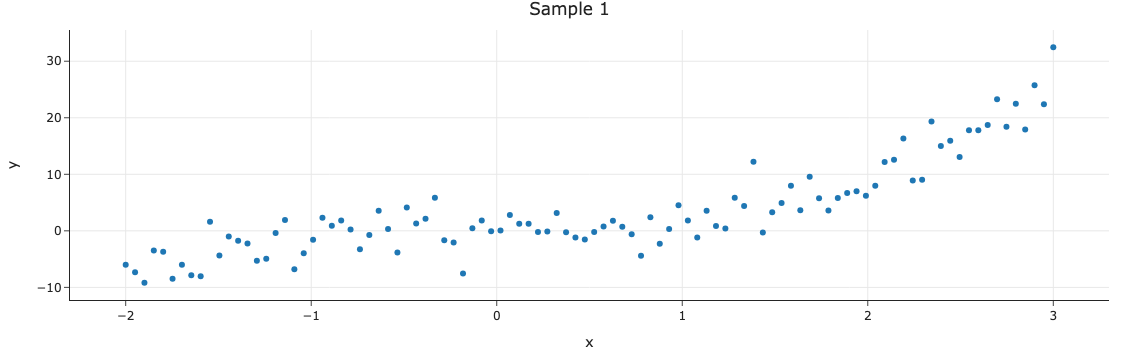

In [136]:
px.scatter(sample_1, x='x', y='y', title='Sample 1')

First, we perform a train-test split.

In [137]:
X = sample_1[['x']]
y = sample_1['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Polynomial degree vs. train/test error

Now, we'll create models with degree-1 through degree-25 polynomial features and compute their train and test errors.

In [138]:
train_errs = []
test_errs = []

for d in range(1, 26):
    pl = make_pipeline(PolynomialFeatures(d), LinearRegression())
    pl.fit(X_train, y_train)
    train_errs.append(root_mean_squared_error(y_train, pl.predict(X_train)))
    test_errs.append(root_mean_squared_error(y_test, pl.predict(X_test)))

errs = pd.DataFrame({'Train Error': train_errs, 'Test Error': test_errs})

Let's look at the plots of training error vs. degree and test error vs. degree.

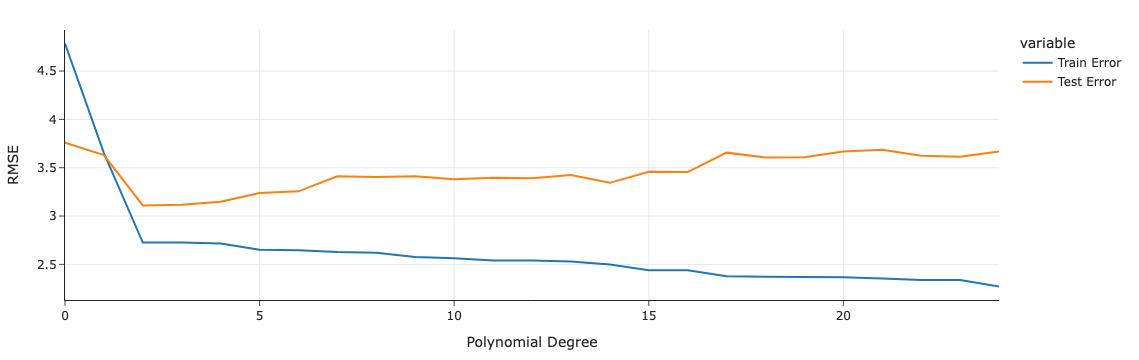

In [139]:
fig = px.line(errs)
fig.update_layout(showlegend=True, xaxis_title='Polynomial Degree', yaxis_title='RMSE')

- Training error appears to decrease as polynomial degree increases.

- Test error appears to decrease until a "valley", and then increases again.

- Here, we'd choose a degree of 3, since that degree has the **lowest test error**.

### Training error vs. test error

The pattern we saw in the previous example is true more generally.

<center><img src='imgs/tt-errors.png' width=50%></center>

We pick the hyperparameter(s) at the "valley" of test error.

Note that training error **tends** to underestimate test error, but it doesn't have to – i.e., it is possible for test error to be lower than training error (say, if the test set is "easier" to predict than the training set).

### Conducting train-test splits

- Recall, <span style='color: blue'><b>training data</b></span> is used to fit our model, and <span style='color: orange'><b>test data</b></span> is used to evaluate our model.

<center><img src='imgs/train-test-first.png' width=40%></center>

- **Question**: _How_ should we split?
    - `sklearn`'s `train_test_split` splits **randomly**, which usually works well.
    - However, if there is some element of **time** in the training data (say, when predicting the future price of a stock), a better split is "past" and "future".

- **Question**: How _large_ should the split be, e.g. 90%-10% vs. 75%-25%?
    - There's a tradeoff – a larger training set should lead to a "better" model, while a larger test set should lead to a better estimate of our model's ability to generalize.
    - There's no "right" choice, but we usually choose between 10% to 25% for the test set.

### But wait...

- With our current strategy, we are choosing the hyperparameter that creates the model that **performs best on the test set**.

- As such, we are **overfitting to the test set** – the best hyperparameter for the test set might not be the best hyperparameter for a totally unseen dataset!

- It seems like we need **another** split.

## Summary, next time

### Summary

- We want to build models that generalize well to unseen data.
    - Models that have **high bias** are **too simple** to represent complex relationships in data, and **underfit**.
    - Models that have **high variance** are **overly complex** for the relationships in the data, and vary a lot when fit on different datasets. Such models **overfit** to the training data.
- A model's training error tends to decrease as model complexity increases, while its test error tends to decrease, before reaching a "sweet spot" and increasing again.
- A hyperparameter is a configuration that we choose before training a model; an important task in machine learning is selecting "good" hyperparameters.

### Next time

We can't choose model hyperparameters just by using a train-test split, because this strategy overfits to the test data.

Is there a better way to choose model hyperparameters? **Yes: cross-validation**.